# Quality control comparison between LIBD and public RNA-seq data
- CMC
- GTEx brain regions

In [1]:
library(tidyverse)
library(synapser)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


New synapser version detected: 
    You are using synapser version 0.9.77.
    synapser version 0.10.101 is detected at http://ran.synapse.org.
    To upgrade to the latest version of synapser, please run the following command:
    install.packages("synapser", repos="http://ran.synapse.org")



TERMS OF USE NOTICE:
  When using Synapse, remember that the terms and conditions of use require that you:
  1) Attribute data contributors when discussing these data or results from these data.
  2) Not discriminate, identify, or recontact individuals or groups represented by the data.
  3) Use and contribute only 

## Load metrics

### Load Lieber RNA-seq metrics

In [2]:
libd = data.table::fread("/ceph/projects/v4_phase3_paper/inputs/phenotypes/_m/merged_phenotypes.csv") %>%
    select(-starts_with("snp"), -c("antipsychotics", "lifetime_antipsych")) %>%
    rename("Percent_Aligned"="overallMapRate", "rRNA_Rate"="rRNA_rate", "Brain_Region"="Region", 
           "SampleID"="RNum")
libd %>% head(2)

SampleID,Sex,Race,Dx,Age,mitoRate,rRNA_Rate,totalAssignedGene,RIN,ERCCsumLogErr,Percent_Aligned,Brain_Region,BrNum,Protocol
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
R11135,Male,EA,CTL,18.77,0.2572796,0.0001690954,0.5231321,5.9,-22.04979,0.8746,HIPPO,Br2063,RiboZeroHMR
R11137,Male,EA,CTL,41.44,0.3840272,0.0000884558,0.5933431,9.2,-29.49833,0.9149,HIPPO,Br2582,RiboZeroHMR


### Load CMC RNA-seq metrics

In [3]:
# Process functions
downloadFile_version <- function(id , version){
  data.table::fread(synGet(id, version = version)$path, data.table = F)
}
synLogin()

# Download clinical metadata 
CLINICAL_ID = 'syn3354385'
clinical = downloadFile_version(CLINICAL_ID, version = 4)

# Download RNASeq metadata
METADATA_QC_DLPFC_ID = 'syn18358379' 
metadata = downloadFile_version(METADATA_QC_DLPFC_ID, version = 3)

# Join clinical and RNASeq metadata 
md = right_join(clinical, metadata, by = c("Individual ID" = "Individual_ID")) %>% 
    mutate(Dx = fct_recode(Dx, AFF_BP = "BP", AFF_BP = "AFF", Other = "undetermined", 
                           Control = "Control", SCZ = "SCZ"))

# Compute read pair metrics and add Institution-Dx variable
md <- md %>%
    select(c("SampleID", "Dx", "Reported Gender", "Sex", "Ethnicity", "pH", "Age of Death",
             "Study", "Brain_Region", "Brodmann_Area", "RIN", "rRNA_Rate", "Percent_Aligned"))
colnames(md) <- gsub(' ', '_', colnames(md))
print(dim(md))
md %>% head(2)

Welcome, kj.benjamin!

NULL

[1] 991  13


,SampleID,Dx,Reported_Gender,Sex,Ethnicity,pH,Age_of_Death,Study,Brain_Region,Brodmann_Area,RIN,rRNA_Rate,Percent_Aligned
,<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,MSSM_RNA_PFC_155,Control,Female,XX,African-American,NA,90+,CMC,DLPFC,9,8.4,0.000250992,0.9798915
2,MSSM_RNA_PFC_280,Control,Female,XX,Caucasian,6.6,90+,CMC,DLPFC,9,8.4,0.000373524,0.9688145


### Load GTEx metrics and 

In [4]:
gtex = data.table::fread(paste0("https://storage.googleapis.com/gtex_analysis_v8/annotations/",
                                "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt")) %>%
    select(c("SAMPID", "SMRIN", "SMTS", "SMTSD", "SMMAPRT", "SMRRNART")) %>%
    filter(SMTS == "Brain") %>% 
    rename("RIN"="SMRIN", "Percent_Aligned"="SMMAPRT", "rRNA_Rate"="SMRRNART", "Brain_Region"="SMTSD", 
           "SampleID"="SAMPID")
gtex %>% head()

SampleID,RIN,SMTS,Brain_Region,Percent_Aligned,rRNA_Rate
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
GTEX-1117F-0011-R10a-SM-AHZ7F,NA,Brain,Brain - Frontal Cortex (BA9),NA,NA
GTEX-1117F-0011-R10b-SM-CYKQ8,7.2,Brain,Brain - Frontal Cortex (BA9),NA,NA
GTEX-1117F-3226-SM-5N9CT,6.2,Brain,Brain - Cortex,0.992538,0.0620363
GTEX-111FC-0011-R10a-SM-AHZ7K,NA,Brain,Brain - Frontal Cortex (BA9),NA,NA
GTEX-111FC-0011-R10a-SM-CYKQ9,8.5,Brain,Brain - Frontal Cortex (BA9),NA,NA
GTEX-111FC-3126-SM-5GZZ2,6.1,Brain,Brain - Cortex,0.992900,0.0363811


## Clean and organize data

In [5]:
gtex = gtex %>% mutate("Dataset"="GTEx", "Dx"="Control", 
                       "Brain_Region"=gsub("Brain - ", "", str_replace(gtex$Brain_Region, "\\(.*", ""))) %>% 
    select("SampleID", "Dx", "Brain_Region", "RIN", "rRNA_Rate", "Percent_Aligned", "Dataset")
gtex$Brain_Region = gsub(" $", "", str_replace(gtex$Brain_Region, "Frontal Cortex", "DLPFC"))
gtex %>% head(2)

SampleID,Dx,Brain_Region,RIN,rRNA_Rate,Percent_Aligned,Dataset
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
GTEX-1117F-0011-R10a-SM-AHZ7F,Control,DLPFC,NA,NA,NA,GTEx
GTEX-1117F-0011-R10b-SM-CYKQ8,Control,DLPFC,7.2,NA,NA,GTEx


In [6]:
cmc = md %>% select("SampleID", "Dx", "Brain_Region", "RIN", "rRNA_Rate", "Percent_Aligned") %>%
    mutate("Dataset"="CMC")
cmc %>% head(2)

,SampleID,Dx,Brain_Region,RIN,rRNA_Rate,Percent_Aligned,Dataset
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,MSSM_RNA_PFC_155,Control,DLPFC,8.4,0.000250992,0.9798915,CMC
2,MSSM_RNA_PFC_280,Control,DLPFC,8.4,0.000373524,0.9688145,CMC


In [7]:
libd = libd %>% select("SampleID", "Dx", "Brain_Region", "RIN", "rRNA_Rate", "Percent_Aligned") %>%
    mutate("Dataset"="LIBD", "Dx"=gsub("CTL", "Control", libd$Dx), 
           "Brain_Region"=gsub("HIPPO", "Hippocampus", libd$Brain_Region))
libd %>% head(2)

SampleID,Dx,Brain_Region,RIN,rRNA_Rate,Percent_Aligned,Dataset
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
R11135,Control,Hippocampus,5.9,0.0001690954,0.8746,LIBD
R11137,Control,Hippocampus,9.2,0.0000884558,0.9149,LIBD


In [8]:
df = bind_rows(libd, gtex, cmc) #%>% mutate_if(is.character, as.factor)
df %>% head(2)

SampleID,Dx,Brain_Region,RIN,rRNA_Rate,Percent_Aligned,Dataset
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
R11135,Control,Hippocampus,5.9,0.0001690954,0.8746,LIBD
R11137,Control,Hippocampus,9.2,0.0000884558,0.9149,LIBD


In [9]:
df$Brain_Region %>% unique

[1] "Hippocampus"               "DLPFC"                    
 [3] "Caudate"                   "Cortex"                   
 [5] "Cerebellum"                "Cerebellar Hemisphere"    
 [7] "Nucleus accumbens"         "Putamen"                  
 [9] "Hypothalamus"              "Spinal cord"              
[11] "Anterior cingulate cortex" "Substantia nigra"         
[13] "Amygdala"

## Descriptive analysis

### Check if NA present

#### GTEx

##### RIN

In [10]:
gtex %>% group_by(Brain_Region) %>% count(is.na(RIN)) %>%
    pivot_wider(names_from=`is.na(RIN)`, values_from="n") %>%
    mutate("TRUE"=replace_na(`TRUE`,0))

Brain_Region,FALSE,TRUE
<chr>,<int>,<dbl>
Amygdala,177,0
Anterior cingulate cortex,213,0
Caudate,291,0
Cerebellar Hemisphere,263,0
Cerebellum,297,1
Cortex,325,0
DLPFC,303,122
Hippocampus,232,11
Hypothalamus,236,0


##### rRNA Rate

In [11]:
gtex %>% group_by(Brain_Region) %>% count(is.na(rRNA_Rate)) %>%
    pivot_wider(names_from=`is.na(rRNA_Rate)`, values_from="n") %>%
    mutate("TRUE"=replace_na(`TRUE`,0))

Brain_Region,FALSE,TRUE
<chr>,<int>,<dbl>
Amygdala,161,16
Anterior cingulate cortex,199,14
Caudate,269,22
Cerebellar Hemisphere,245,18
Cerebellum,275,23
Cortex,280,45
DLPFC,221,204
Hippocampus,214,29
Hypothalamus,219,17


##### Percent Alignment

In [12]:
gtex %>% group_by(Brain_Region) %>% count(is.na(Percent_Aligned)) %>%
    pivot_wider(names_from=`is.na(Percent_Aligned)`, values_from="n") %>%
    mutate("TRUE"=replace_na(`TRUE`,0))

Brain_Region,FALSE,TRUE
<chr>,<int>,<dbl>
Amygdala,161,16
Anterior cingulate cortex,199,14
Caudate,269,22
Cerebellar Hemisphere,245,18
Cerebellum,275,23
Cortex,280,45
DLPFC,221,204
Hippocampus,214,29
Hypothalamus,219,17


#### CMC

##### RIN

In [13]:
cmc %>% group_by(Brain_Region) %>% count(is.na(RIN))

Brain_Region,is.na(RIN),n
<chr>,<lgl>,<int>
DLPFC,FALSE,991


##### rRNA Rate

In [14]:
cmc %>% group_by(Brain_Region) %>% count(is.na(rRNA_Rate))

Brain_Region,is.na(rRNA_Rate),n
<chr>,<lgl>,<int>
DLPFC,FALSE,991


##### Percent Alignment

In [15]:
cmc %>% group_by(Brain_Region) %>% count(is.na(Percent_Aligned))

Brain_Region,is.na(Percent_Aligned),n
<chr>,<lgl>,<int>
DLPFC,FALSE,991


#### LIBD

##### RIN

In [16]:
libd %>% group_by(Brain_Region) %>% count(is.na(RIN))

Brain_Region,is.na(RIN),n
<chr>,<lgl>,<int>
Caudate,FALSE,464
DLPFC,FALSE,453
Hippocampus,FALSE,447


##### rRNA Rate

In [17]:
libd %>% group_by(Brain_Region) %>% count(is.na(rRNA_Rate))

Brain_Region,is.na(rRNA_Rate),n
<chr>,<lgl>,<int>
Caudate,FALSE,464
DLPFC,FALSE,453
Hippocampus,FALSE,447


##### Percent Alignment

In [18]:
libd %>% group_by(Brain_Region) %>% count(is.na(Percent_Aligned))

Brain_Region,is.na(Percent_Aligned),n
<chr>,<lgl>,<int>
Caudate,FALSE,464
DLPFC,FALSE,453
Hippocampus,FALSE,447


### Summarize data

In [19]:
df %>% group_by(Dataset, Brain_Region) %>%
    summarise(RIN_mean=mean(RIN, na.rm=TRUE), RIN_sd=sd(RIN, na.rm=TRUE), 
              rRNA_mean=mean(rRNA_Rate, na.rm=TRUE), rRNA_sd=sd(rRNA_Rate, na.rm=TRUE), 
              PercentAligned_mean=mean(Percent_Aligned, na.rm=TRUE), 
              PercentAligned_sd=sd(Percent_Aligned, na.rm=TRUE))

`summarise()` has grouped output by 'Dataset'. You can override using the `.groups` argument.



Dataset,Brain_Region,RIN_mean,RIN_sd,rRNA_mean,rRNA_sd,PercentAligned_mean,PercentAligned_sd
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CMC,DLPFC,7.595863,0.9002318,2.825332e-04,1.016402e-04,0.9566296,0.03183684
GTEx,Amygdala,6.594915,0.6356163,8.679170e-02,3.724921e-02,0.9595594,0.10061814
GTEx,Anterior cingulate cortex,6.683568,0.7626681,7.020330e-02,3.407544e-02,0.9702657,0.10890287
GTEx,Caudate,7.390034,0.8786767,6.669918e-02,2.858002e-02,0.9673060,0.09202739
GTEx,Cerebellar Hemisphere,7.457034,1.0033617,2.524327e-02,2.178709e-02,0.9781349,0.06439738
GTEx,Cerebellum,6.851852,0.7893323,2.060865e-02,1.212267e-02,0.9800255,0.04482617
GTEx,Cortex,6.588308,0.6811292,4.852958e-02,2.031282e-02,0.9748030,0.09817281
GTEx,DLPFC,7.168647,0.8580205,5.299829e-02,2.901991e-02,0.9750652,0.07538783
GTEx,Hippocampus,6.765517,0.7559981,7.530126e-02,3.385451e-02,0.9583929,0.12232209


## Plot metrics

In [20]:
save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

Warning message:
“Removed 134 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 134 rows containing missing values (geom_point).”
Warning message:
“Removed 134 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 134 rows containing missing values (geom_point).”
Warning message:
“Removed 134 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 134 rows containing missing values (geom_point).”
Warning message:
“Removed 134 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 134 rows containing missing values (geom_point).”


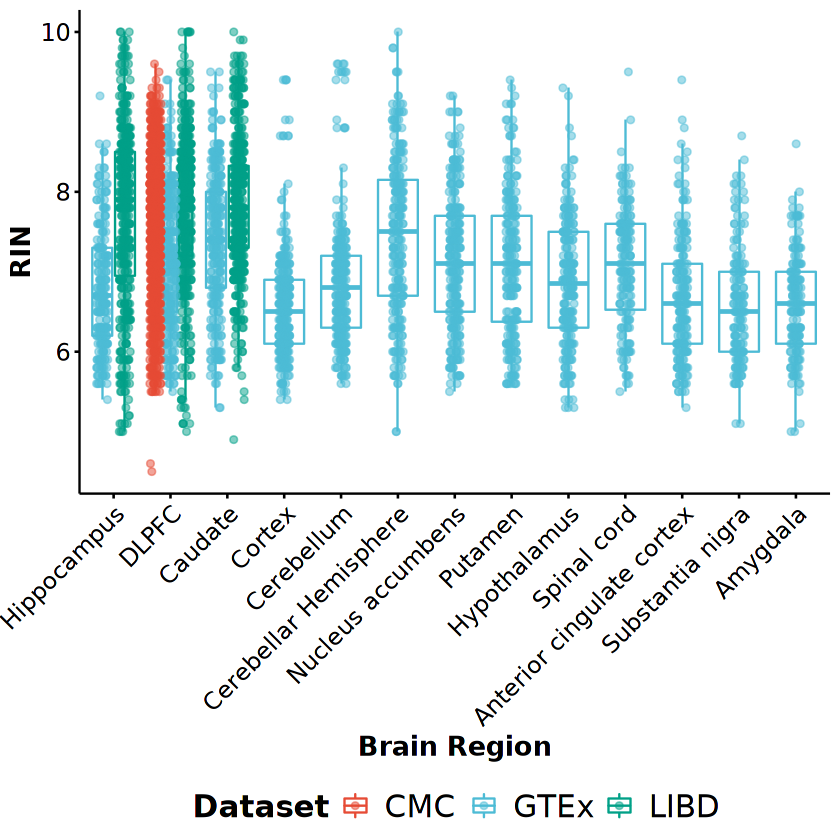

In [21]:
bxp = df %>% ggboxplot(x="Brain_Region", y="RIN", color="Dataset", add='jitter', 
                       panel.labs.font=list(face='bold', size = 14), palette="npg", 
                       outlier.shape=NA, ylab='RIN', add.params=list(alpha=0.5), 
                       legend="bottom", xlab="Brain Region") +
    font("xy.text", size=14) + font("xy.title", size=16, face="bold") + 
    font("legend.title", size=18, face="bold") + font("legend.text", size=18) +
    rotate_x_text(45)
save_ggplots("boxplot_brain_region_comparison_rin", bxp, 12, 8)
bxp

Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”
Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”
Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”
Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”


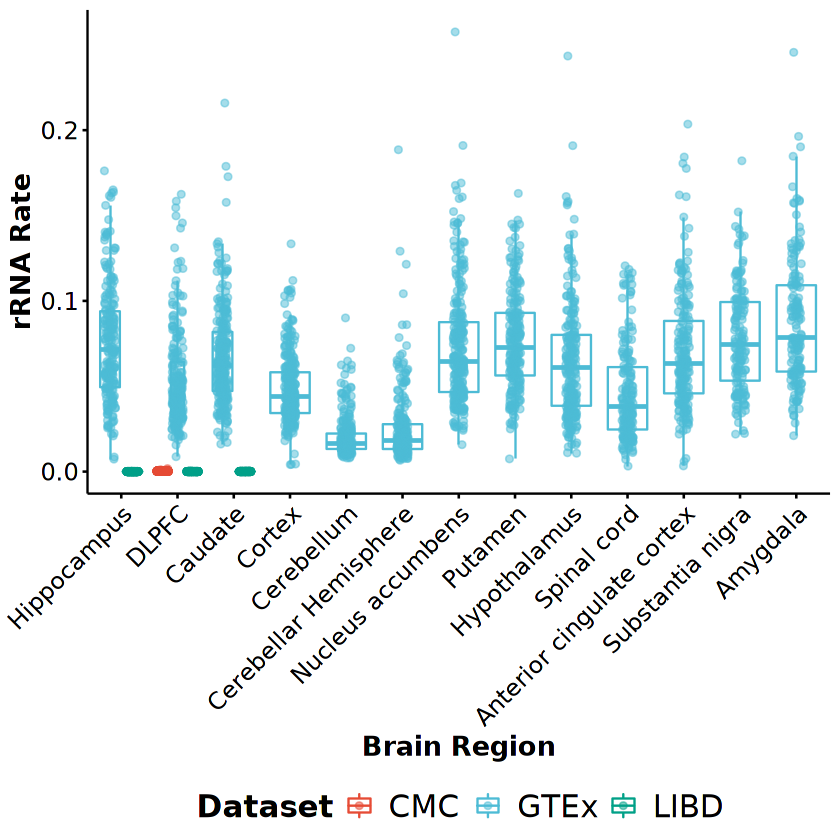

In [22]:
bxp = df %>% ggboxplot(x="Brain_Region", y="rRNA_Rate", color="Dataset", add='jitter', 
                       panel.labs.font=list(face='bold', size = 14), palette="npg", 
                       outlier.shape=NA, ylab='rRNA Rate', add.params=list(alpha=0.5), 
                       legend="bottom", xlab="Brain Region") +
    font("xy.text", size=14) + font("xy.title", size=16, face="bold") + 
    font("legend.title", size=18, face="bold") + font("legend.text", size=18) +
    rotate_x_text(45)
save_ggplots("boxplot_brain_region_comparison_rRNA_rate", bxp, 12, 8)
bxp

Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”
Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”
Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”
Warning message:
“Removed 445 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 445 rows containing missing values (geom_point).”


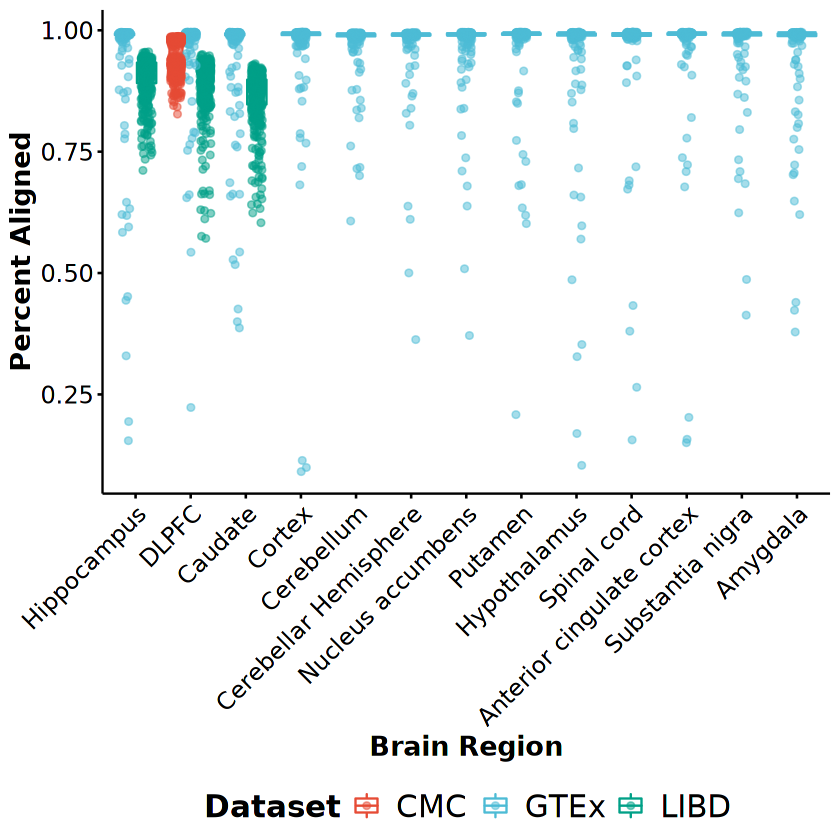

In [23]:
bxp = df %>% ggboxplot(x="Brain_Region", y="Percent_Aligned", color="Dataset", add='jitter', 
                       panel.labs.font=list(face='bold', size = 14), palette="npg", 
                       outlier.shape=NA, ylab='Percent Aligned', add.params=list(alpha=0.5), 
                       legend="bottom", xlab="Brain Region") +
    font("xy.text", size=14) + font("xy.title", size=16, face="bold") + 
    font("legend.title", size=18, face="bold") + font("legend.text", size=18) +
    rotate_x_text(45)
save_ggplots("boxplot_brain_region_comparison_Percent_Aligned", bxp, 12, 8)
bxp

## Session Info

In [24]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-12 15:50:21 EDT"

   user  system elapsed 
 17.106   0.769  15.800 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-12                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package        * version  date       lib source        
 abind            1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat       0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports        1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc        0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom            0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 Cairo            1.5-12.2 20